In [1]:
pip install -U imbalanced-learn

     |████████████████████████████████| 174kB 2.8MB/s 
     |████████████████████████████████| 6.8MB 8.4MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [2]:
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM, LSTM, SimpleRNN, GRU, Bidirectional, RepeatVector
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout

from tensorflow.keras import regularizers

from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [3]:
import glob
import pandas as pd
import math
from imblearn.over_sampling import SMOTE, KMeansSMOTE
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
all_filenames = [i for i in glob.glob('/content/drive/My Drive/TrainingData/*.{}'.format('csv'))]

In [6]:
df_x, df_x_time, df_y, df_y_time = [], [], [], []
for f in all_filenames:
    if f.endswith('x.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_x.append(df)
    if f.endswith('x_time.csv'):
      df = pd.read_csv(f, header=None)
      df_x_time.append(df)
    if f.endswith('y.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_y.append(df)
    if f.endswith('y_time.csv'):
      df = pd.read_csv(f, header=None)
      df_y_time.append(df)
    
x = pd.concat(df_x, ignore_index=True)
x.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'subject', 'subject_ID']
x_time = pd.concat(df_x_time, ignore_index=True)
x_time.columns = ['x_time']
y = pd.concat(df_y, ignore_index=True)
y.columns = ['y', 'subject', 'subject_ID']
y_time = pd.concat(df_y_time, ignore_index=True)
y_time.columns = ['y_time']
x['time'] = x_time['x_time']
y['time'] = y_time['y_time']
y['time'] = [round(x+0.005,3) for x in y['time']]

In [ ]:
# x.drop(x[x['time'] == 0].index, inplace = True)

In [ ]:
# x.drop(x[x['time'] == 0.025].index, inplace = True)

In [7]:
full_df = pd.merge(x,y, on=['time','subject', 'subject_ID'], how='left')

In [8]:
full_df.head(20)

,x1,x2,x3,x4,x5,x6,subject,subject_ID,time,y
0,4.435275,8.196063,2.974488,0.014215,-0.039157,-0.016744,001,01,0.000,NaN
1,4.186920,8.344455,2.908057,0.005771,-0.004480,-0.003345,001,01,0.025,0.0
2,4.544637,8.408659,2.890000,0.007967,0.022412,0.001159,001,01,0.050,NaN
3,4.849308,8.411614,2.900692,0.027778,-0.010670,-0.014223,001,01,0.075,NaN
4,4.509190,8.118649,2.847298,0.021577,-0.045498,-0.021111,001,01,0.100,NaN
5,4.226515,8.273807,2.851742,0.012534,0.000445,-0.016830,001,01,0.125,0.0
6,4.532063,8.398341,2.856682,0.014484,0.028769,-0.011091,001,01,0.150,NaN
7,4.433669,8.294719,2.823521,0.016340,-0.029434,-0.008998,001,01,0.175,NaN
8,4.160676,8.260676,2.827568,0.011222,-0.016748,-0.006027,001,01,0.200,NaN
9,4.432763,8.272613,2.790050,-0.002715,0.023094,0.012222,001,01,0.225,0.0


In [9]:
full_df['y'] = full_df['y'].interpolate(method='nearest')

In [10]:
full_df.isna().sum()

x1            0
x2            0
x3            0
x4            0
x5            0
x6            0
subject       0
subject_ID    0
time          0
y             1
dtype: int64

In [11]:
full_df.dropna(inplace=True)

In [12]:
full_df.shape

(1367083, 10)

In [13]:
from numpy import array
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
	# end_flag = True 
	# for i in range(0,len(sequences),1):
  #   # find the end of this pattern
	# 	end_ix = i + n_steps
  #   # check if we are beyond the dataset
	# 	if end_ix > len(sequences):
	# 		end_flag = False
	# 		seq_x, seq_y = sequences[-1:, :], sequences[end_ix-1, -1]
	# 		X.append(seq_x)
	# 		y.append(seq_y)
	# 		break
	# 	# gather input and output parts of the pattern
	# 	if (end_flag):
	# 		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
	# 		X.append(seq_x)
	# 		y.append(seq_y)
	# return array(X), array(y)

In [14]:
in_seq1 = full_df['x1'].to_numpy().reshape((len(full_df['x1']), 1))
in_seq2 = full_df['x2'].to_numpy().reshape((len(full_df['x2']), 1))
in_seq3 = full_df['x3'].to_numpy().reshape((len(full_df['x3']), 1))
in_seq4 = full_df['x4'].to_numpy().reshape((len(full_df['x4']), 1))
in_seq5 = full_df['x5'].to_numpy().reshape((len(full_df['x5']), 1))
in_seq6 = full_df['x6'].to_numpy().reshape((len(full_df['x6']), 1))

In [15]:
out_seq = full_df['y'].to_numpy().reshape((len(full_df['y']), 1))

In [16]:
dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, out_seq))

In [18]:
X, y = split_sequences(dataset, 10)

In [22]:
ind = np.argwhere(np.isnan(y)).flatten()

In [24]:
allrows = np.array(range(len(X)))
X_n = X[np.setdiff1d(allrows,ind)]

In [25]:
y = y[~np.isnan(y)]

In [26]:
X_n.shape

(1367074, 10, 6)

In [28]:
y = y.reshape(-1,1)

In [29]:
y.shape

(1367074, 1)

In [30]:
unique, counts = np.unique(y, return_counts=True)

In [31]:
print(unique)
print(counts)

[0. 1. 2. 3.]
[1018028   81575   60189  207282]


In [59]:
# RNN Model with LSTM
model = Sequential()
# model.add(Embedding(130, 128, input_length=num_steps))
# model.add(Dropout(0.7))
model.add(LSTM(128, input_shape=(10,6), recurrent_activation='swish', return_sequences=True))
model.add(BatchNormalization())
# model.add(Bidirectional(LSTM(128, recurrent_activation='swish', return_sequences=True)))
model.add(BatchNormalization())
model.add(LSTM(64, recurrent_activation='swish'))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy', f1_m], sample_weight_mode="temporal")
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 10, 128)           69120     
_________________________________________________________________
batch_normalization_15 (Batc (None, 10, 128)           512       
_________________________________________________________________
batch_normalization_16 (Batc (None, 10, 128)           512       
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
batch_normalization_17 (Batc (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 120,068
Trainable params: 119,428
Non-trainable params: 640
______________________________________________

In [60]:
model.output_shape

(None, 4)

In [61]:
model.input_shape

(None, 10, 6)

In [68]:
# CNN model
model_CNN1 = Sequential()

#Adding the input layer and first hidden layer
model_CNN1.add(Dense(256, activation= 'swish', input_shape=(1,24)))
# model_CNN1.add(Dropout(0.25))
#Adding second hidden layer
model_CNN1.add(Dense(512, activation= 'swish'))
model_CNN1.add(BatchNormalization())
# model_CNN1.add(Dropout(0.25))
model_CNN1.add(Dense(256, activation= 'swish'))
model_CNN1.add(BatchNormalization())
model_CNN1.add(Dense(128, activation= 'swish'))
model_CNN1.add(BatchNormalization())
model_CNN1.add(Dense(64, activation= 'swish'))
model_CNN1.add(BatchNormalization())
#Adding the Output Layer
model_CNN1.add(TiDense(4, activation='softmax')) 
#Compiling
model_CNN1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_m, 'categorical_accuracy'])
model_CNN1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1, 256)            6400      
_________________________________________________________________
dense_15 (Dense)             (None, 1, 512)            131584    
_________________________________________________________________
batch_normalization_24 (Batc (None, 1, 512)            2048      
_________________________________________________________________
dense_16 (Dense)             (None, 1, 256)            131328    
_________________________________________________________________
batch_normalization_25 (Batc (None, 1, 256)            1024      
_________________________________________________________________
dense_17 (Dense)             (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_26 (Batc (None, 1, 128)           

In [164]:
# CNN model
model_CNN = Sequential()

#Adding the input layer and first hidden layer
model_CNN.add(Dense(256, activation= 'swish', input_shape=(1,60)))
#Adding second hidden layer
model_CNN.add(Dense(512, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(512, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(256, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(128, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(64, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(32, activation= 'swish'))
model_CNN.add(BatchNormalization())
#Adding the Output Layer
model_CNN.add(Dense(4, activation='softmax')) 
#Compiling
model_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', f1_m], sample_weight_mode="temporal")
model_CNN.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 1, 256)            15616     
_________________________________________________________________
dense_54 (Dense)             (None, 1, 512)            131584    
_________________________________________________________________
batch_normalization_52 (Batc (None, 1, 512)            2048      
_________________________________________________________________
dense_55 (Dense)             (None, 1, 512)            262656    
_________________________________________________________________
batch_normalization_53 (Batc (None, 1, 512)            2048      
_________________________________________________________________
dense_56 (Dense)             (None, 1, 256)            131328    
_________________________________________________________________
batch_normalization_54 (Batc (None, 1, 256)          

In [165]:
model_CNN.input_shape

(None, 1, 60)

In [166]:
model_CNN.output_shape

(None, 1, 4)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_n, y, test_size=0.3, random_state=177)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(full_df[['x1','x2','x3', 'x4', 'x5', 'x6']], full_df['y'], test_size=0.3, random_state=177)

In [42]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,60))
X_test = scaler.transform(X_test.reshape(-1,60))

In [43]:
X_train = X_train.reshape(-1,10,6)
X_test = X_test.reshape(-1,10,6)

In [ ]:
model.input_shape

(None, 100, 7)

In [ ]:
model.output_shape

(None, 1)

In [44]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)

[0. 1. 2. 3.]
[712814  57072  42035 145030]


In [45]:
# Over Sampling Classes 1 and 2 using kmeansSMOTE
oversample = KMeansSMOTE(sampling_strategy={1:200000, 2:200000}, cluster_balance_threshold=0.02, k_neighbors=3)

In [46]:
X_train = X_train.reshape(-1,60)

In [47]:
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [48]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)

[0. 1. 2. 3.]
[712814 200006 200004 145030]


In [168]:
len(y_train)

1257854

In [169]:
# Ading class weight parameter in CNN models
class_weights = np.zeros((len(y_train), 4))
class_weights[:, 0] += 1
class_weights[:, 1] += 20
class_weights[:, 2] += 18
class_weights[:, 3] += 5

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)

In [ ]:
print(unique)
print(counts)

[0. 1.]
[3772014 1257338]


In [79]:
# Reshape inputs according to input shape
X_train = X_train.reshape(-1,1,60)
X_test = X_test.reshape(-1,1,60)

In [82]:
X_train.shape

(1257854, 1, 60)

In [83]:
y_train.shape

(1257854, 1, 4)

In [84]:
model_CNN.output_shape

(None, 1, 4)

In [52]:
# Reshape according to model output size
y_train = to_categorical(y_train).reshape(-1,4)
y_test = to_categorical(y_test).reshape(-1,4)

In [74]:
y_train = y_train.reshape(-1,1,4)
y_test = y_test.reshape(-1,1,4)

In [170]:
# Saving best model each time
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('/content/drive/My Drive/CNN10tsweight611{epoch:08d}.h5', save_best_only=True) 

In [171]:
CNN_10ts_weight = model_CNN.fit(X_train, y_train, epochs = 40, validation_data= (X_test, y_test), callbacks=[checkpoint], batch_size=400, sample_weight=class_weights)

Epoch 1/40
3145/3145 [==============================] - 159s 51ms/step - loss: 9.5079 - categorical_accuracy: 0.6667 - f1_m: 0.6431 - val_loss: 0.7919 - val_categorical_accuracy: 0.7158 - val_f1_m: 0.7055
Epoch 2/40
3145/3145 [==============================] - 162s 51ms/step - loss: 8.0970 - categorical_accuracy: 0.7196 - f1_m: 0.7120 - val_loss: 0.7423 - val_categorical_accuracy: 0.7328 - val_f1_m: 0.7243
Epoch 3/40
3145/3145 [==============================] - 163s 52ms/step - loss: 7.2881 - categorical_accuracy: 0.7492 - f1_m: 0.7440 - val_loss: 0.7105 - val_categorical_accuracy: 0.7456 - val_f1_m: 0.7395
Epoch 4/40
3145/3145 [==============================] - 163s 52ms/step - loss: 6.7238 - categorical_accuracy: 0.7693 - f1_m: 0.7651 - val_loss: 0.7016 - val_categorical_accuracy: 0.7510 - val_f1_m: 0.7470
Epoch 5/40
3145/3145 [==============================] - 161s 51ms/step - loss: 6.3130 - categorical_accuracy: 0.7835 - f1_m: 0.7803 - val_loss: 0.6949 - val_categorical_accuracy: 0

In [86]:
CNN_10ts = model_CNN.fit(X_train, y_train, epochs = 20, validation_data= (X_test, y_test), callbacks=[checkpoint], batch_size=240)

Epoch 1/20
5242/5242 [==============================] - 189s 36ms/step - loss: 0.8930 - categorical_accuracy: 0.6530 - f1_m: 0.6309 - val_loss: 0.8035 - val_categorical_accuracy: 0.7083 - val_f1_m: 0.6958
Epoch 2/20
5242/5242 [==============================] - 186s 35ms/step - loss: 0.7783 - categorical_accuracy: 0.7025 - f1_m: 0.6935 - val_loss: 0.7542 - val_categorical_accuracy: 0.7281 - val_f1_m: 0.7189
Epoch 3/20
5242/5242 [==============================] - 190s 36ms/step - loss: 0.7191 - categorical_accuracy: 0.7270 - f1_m: 0.7203 - val_loss: 0.7363 - val_categorical_accuracy: 0.7318 - val_f1_m: 0.7247
Epoch 4/20
5242/5242 [==============================] - 192s 37ms/step - loss: 0.6810 - categorical_accuracy: 0.7422 - f1_m: 0.7367 - val_loss: 0.7068 - val_categorical_accuracy: 0.7472 - val_f1_m: 0.7421
Epoch 5/20
5242/5242 [==============================] - 193s 37ms/step - loss: 0.6541 - categorical_accuracy: 0.7527 - f1_m: 0.7480 - val_loss: 0.7035 - val_categorical_accuracy: 0

In [ ]:
CNN_swish = model_CNN.fit(X_train, y_train, epochs = 40, validation_data= (X_test, y_test), callbacks=[checkpoint], batch_size=240, sample_weight=class_weights)

Epoch 1/40
5239/5239 [==============================] - 181s 34ms/step - loss: 8.1394 - categorical_accuracy: 0.7152 - f1_m: 0.7072 - val_loss: 0.7740 - val_categorical_accuracy: 0.7152 - val_f1_m: 0.7086
Epoch 2/40
5239/5239 [==============================] - 179s 34ms/step - loss: 7.5910 - categorical_accuracy: 0.7366 - f1_m: 0.7311 - val_loss: 0.7755 - val_categorical_accuracy: 0.7143 - val_f1_m: 0.7074
Epoch 3/40
5239/5239 [==============================] - 179s 34ms/step - loss: 7.3361 - categorical_accuracy: 0.7467 - f1_m: 0.7418 - val_loss: 0.7632 - val_categorical_accuracy: 0.7212 - val_f1_m: 0.7158
Epoch 4/40
5239/5239 [==============================] - 181s 35ms/step - loss: 7.1440 - categorical_accuracy: 0.7547 - f1_m: 0.7505 - val_loss: 0.7523 - val_categorical_accuracy: 0.7266 - val_f1_m: 0.7214
Epoch 5/40
5239/5239 [==============================] - 178s 34ms/step - loss: 6.9978 - categorical_accuracy: 0.7601 - f1_m: 0.7560 - val_loss: 0.7438 - val_categorical_accuracy: 0

In [ ]:
RNN_history = model.fit(X_train, y_train, epochs = 40, validation_data= (X_test, y_test), callbacks=[checkpoint], batch_size=240)


In [ ]:
model_CNN.output_shape

(None, 1, 4)

In [ ]:
# Load model if needed
from keras.models import load_model
CNN_model = load_model('/content/drive/My Drive/CNNdnkmfull41100000023.h5', custom_objects={'f1_m': f1_m})

In [138]:
# Function to split test data into proper inputs
def split_test_sequences(sequences, n_steps):
  X = list()
  end_flag = True 
  for i in range(0,len(sequences)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(sequences):
      end_flag = False
      for j in range(i, len(sequences)):  
        seq_x = sequences[j:, :]
        if seq_x.shape[0] < 10:
          add_x = sequences[-(10-seq_x.shape[0]):,:]
          seq_x = np.r_[seq_x, add_x]
        X.append(seq_x)
      break
    # gather input and output parts of the pattern
    if (end_flag):
      seq_x = sequences[i:end_ix, :]
      X.append(seq_x)
  return array(X)

In [88]:
model_CNN.input_shape

(None, 1, 60)

In [163]:
# Code block to transform the test data into inputs and join with y_time to get the prediction at that specific y_time
test_filenames = [i for i in glob.glob('/content/drive/My Drive/TestData/*.{}'.format('csv'))]
df_x, df_x_time, df_y_time = [], [], []
for f in test_filenames:
  if '012' in f:
    if f.endswith('x.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_x.append(df)
    if f.endswith('x_time.csv'):
      df = pd.read_csv(f, header=None)
      df_x_time.append(df)
    if f.endswith('y_time.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_y_time.append(df)
    
test_x = pd.concat(df_x, ignore_index=True)
test_x.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'subject', 'subject_ID']
test_x_time = pd.concat(df_x_time, ignore_index=True)
test_x_time.columns = ['x_time']
test_y_time = pd.concat(df_y_time, ignore_index=True)
test_y_time.columns = ['time', 'subject', 'subject_ID']
test_x['time'] = test_x_time['x_time']
test_y_time['time'] = [round(x + 0.005,3) for x in test_y_time['time']]
final_test = pd.merge(test_x, test_y_time, on=['time', 'subject', 'subject_ID'], how='left')
in_seq1 = final_test['x1'].to_numpy().reshape((len(final_test['x1']), 1))
in_seq2 = final_test['x2'].to_numpy().reshape((len(final_test['x2']), 1))
in_seq3 = final_test['x3'].to_numpy().reshape((len(final_test['x3']), 1))
in_seq4 = final_test['x4'].to_numpy().reshape((len(final_test['x4']), 1))
in_seq5 = final_test['x5'].to_numpy().reshape((len(final_test['x5']), 1))
in_seq6 = final_test['x6'].to_numpy().reshape((len(final_test['x6']), 1))
dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6))
test_x = split_test_sequences(dataset, 10)
# scaler = StandardScaler()
test_x = scaler.transform(test_x.reshape(-1,60))
test = test_x.reshape(-1,1,60)
y_pred = model_CNN.predict(test)
y_pred = np.argmax(y_pred.reshape(-1,4), axis=1)
final_test['y_pred'] = y_pred
pred = pd.merge(final_test, test_y_time, on=['time', 'subject', 'subject_ID'], how='inner')['y_pred']
pred.to_csv("subject_012_01__y_prediction.csv", index=False, header=False)
# np.savetxt("subject_009_01__y_prediction.csv", y_pred, delimiter=",")

In [162]:
pred.shape

(12940,)

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss graphs
def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

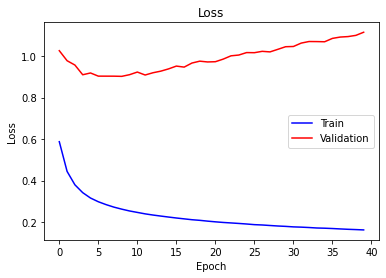

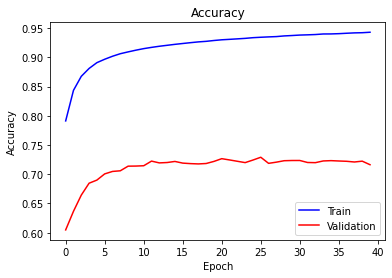

In [ ]:
plot_history(CNN_Swish_history)

In [ ]:
# Plotting f1 metric
plt.plot(RNN_history.history['f1_m'], color='blue', label='train')
plt.plot(RNN_history.history['val_f1_m'], color='red', label='test')
plt.ylabel('F1 Scores')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

In [87]:
# Classification report for the model on the test data we split using test_train_split
from sklearn.metrics import classification_report
y_p = model_CNN.predict(X_test)
y_p = np.argmax(y_p.reshape(-1,4), axis=1)
y_test_n = np.argmax(y_test.reshape(-1,4), axis=1)
print(classification_report(y_test_n, y_p))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86    305214
           1       0.42      0.40      0.41     24503
           2       0.47      0.25      0.33     18154
           3       0.66      0.38      0.49     62252

    accuracy                           0.77    410123
   macro avg       0.59      0.49      0.52    410123
weighted avg       0.75      0.77      0.75    410123



In [172]:
from sklearn.metrics import classification_report
y_p = model_CNN.predict(X_test)
y_p = np.argmax(y_p.reshape(-1,4), axis=1)
y_test_n = np.argmax(y_test.reshape(-1,4), axis=1)
print(classification_report(y_test_n, y_p))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85    305214
           1       0.42      0.40      0.41     24503
           2       0.40      0.29      0.34     18154
           3       0.58      0.43      0.50     62252

    accuracy                           0.76    410123
   macro avg       0.56      0.50      0.52    410123
weighted avg       0.74      0.76      0.75    410123



In [ ]:
from sklearn.metrics import classification_report
y_p = model.predict(X_test)
y_p = np.argmax(y_p.reshape(-1,4), axis=1)
y_test_n = np.argmax(y_test.reshape(-1,4), axis=1)
print(classification_report(y_test_n, y_p))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84    304469
           1       0.33      0.20      0.25     27394
           2       0.28      0.18      0.22     15429
           3       0.57      0.22      0.31     62833

    accuracy                           0.73    410125
   macro avg       0.49      0.38      0.41    410125
weighted avg       0.70      0.73      0.70    410125



In [ ]:
y_test_n = np.argmax(y_test.reshape(-1,4), axis=1)
print(classification_report(y_test_n, y_p))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85    304469
           1       0.38      0.29      0.33     27394
           2       0.35      0.20      0.25     15429
           3       0.62      0.27      0.38     62833

    accuracy                           0.75    410125
   macro avg       0.54      0.42      0.45    410125
weighted avg       0.72      0.75      0.72    410125



In [ ]:
from sklearn.metrics import classification_report
y_p = model.predict(X_test)
y_p = np.argmax(y_p.reshape(-1,4), axis=1)
# y_test = np.argmax(y_test.reshape(-1,1,4), axis=1)
print(classification_report(y_test, y_p))

              precision    recall  f1-score   support

           0       0.78      0.26      0.39    304469
           1       0.11      0.21      0.15     27394
           2       0.06      0.62      0.10     15429
           3       0.27      0.36      0.31     62833

    accuracy                           0.29    410125
   macro avg       0.30      0.36      0.24    410125
weighted avg       0.63      0.29      0.35    410125

